In [57]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import unets_repo
from keras import backend as K

In [2]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data"

def load_data(ids,suj_path,mask_path):
  suj_files = os.listdir(suj_path)
  mask_files = os.listdir(mask_path)
  X = []
  Y = []

  for i in ids:
    x = np.load(os.path.join(suj_path,suj_files[i]))
    y = np.load(os.path.join(mask_path,mask_files[i]))

    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)
def batch_generator(suj_path, mask_path):
    suj_files = os.listdir(suj_path)
    indices = np.arange(len(suj_files))
    indices = np.random.permutation(indices)
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    yield load_data(batch,suj_path,mask_path)
                    batch=[]

train_gen_ds = batch_generator(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))
val_gen_ds = batch_generator(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))

In [3]:
def Dice(targets, inputs):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + K.epsilon()) / (K.sum(targets) + K.sum(inputs) + K.epsilon())

def Jaccard(targets, inputs):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    inputs = tf.cast(inputs, dtype=tf.double)
    targets = tf.cast(targets, dtype=tf.double)
    
    intersection = K.sum(K.abs(inputs * targets))
    union = K.sum(inputs) + K.sum(targets) - intersection
    
    return (intersection + K.epsilon())/(union + K.epsilon())

In [4]:
batch_size = 1
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos")))
vspe = n_val_img//batch_size

In [7]:
attunetselu = unets_repo.AttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
attunetselu.load_weights("modelsh5/0.8160_attunet_selu_lecun_aug_dicebce.h5")
unet3 = unets_repo.unet3plus(input_size=(256,256,1))
unet3.load_weights("modelsh5/0.5662_unet3plus_relu_aug_dicebce.h5")
vsunet = unets_repo.UNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=16)
vsunet.load_weights("modelsh5/0.8174_unet_v_small_selu_lecun_aug_dice.h5")
sunet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=32)
sunet.load_weights("modelsh5/0.7947_unet_small_relu_he_aug.h5")
unet = unets_repo.UNet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=64)
unet.load_weights("modelsh5/0.8134_unet_relu_he_aug.h5")
unetselu = unets_repo.UNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
unetselu.load_weights("modelsh5/0.8314_unet_selu_lecun_aug_dicebce.h5")
restattunet = unets_repo.ResAttUnet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
restattunet.load_weights("modelsh5/0.7741_resattunet_selu_lecun_aug_dicebce.h5")
classicunet = unets_repo.classicUNet(input_size=(256,256,1),activation="selu",initializer="lecun_normal",num_filters=64)
classicunet.load_weights("modelsh5/0.8233_classicunet_selu_lecun_aug_dicebce.h5")
attunet = unets_repo.AttUnet(input_size=(256,256,1),activation="relu",initializer="he_uniform",num_filters=64)
attunet.load_weights("modelsh5/0.8042_attunet_relu_aug_dicebce.h5")

In [179]:
nets = [attunetselu,unet3,vsunet,sunet,unet,unetselu,restattunet,classicunet,attunet]
netnames = ["AttUnet w/s","Unet3+","vsUnet","sUnet","Unet","Unet w/s","ResAttUnet","ClassicUnet","AttUnet"]

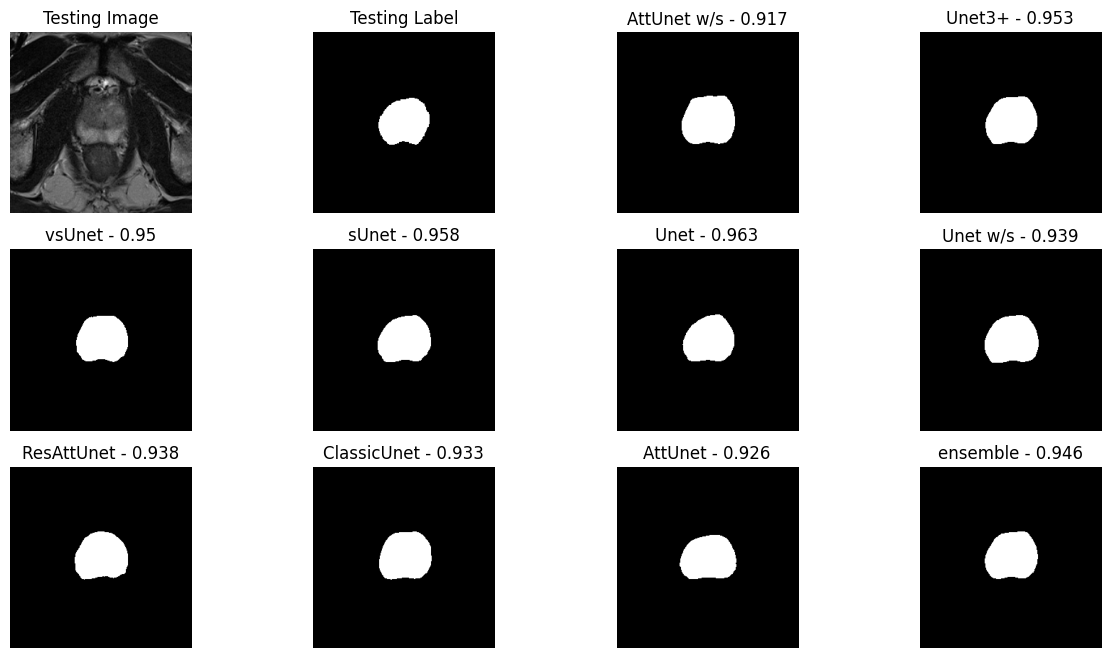

In [360]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth = test_mask_batch[test_img_number]
test_img_norm  =test_img[:,:]
test_img_input = np.expand_dims(test_img_norm, 0)

plt.figure(figsize=(15,8))
plt.subplot(341)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.axis("off")
plt.subplot(342)
plt.title('Testing Label')
plt.imshow(ground_truth>0.5, cmap='gray')
plt.axis("off")
for i,n in enumerate(nets):
    prediction = n(test_img_input).numpy()
    predicted_img_th = (prediction[0,:,:,0]>0.5)*1
    dice = Dice(ground_truth,predicted_img_th).numpy()
    plt.subplot(3,4,i+3)
    plt.title(netnames[i]+" - "+str(round(dice,3)))
    plt.imshow(predicted_img_th, cmap='gray')
    plt.axis("off")
#prediction = nets[0](test_img_input).numpy()*614/1228 + nets[1](test_img_input).numpy()*106/1228 + nets[2](test_img_input).numpy()*62/1228 + nets[3](test_img_input).numpy()*85/1228 + nets[4](test_img_input).numpy()*80/1228 + nets[5](test_img_input).numpy()*65/1228 + nets[6](test_img_input).numpy()*77/1228 + nets[7](test_img_input).numpy()*69/1228 + nets[8](test_img_input).numpy()*70/1228
prediction = nets[0](test_img_input).numpy()*704/1228 + nets[1](test_img_input).numpy()*169/1228 + nets[3](test_img_input).numpy()*192/1228 + nets[4](test_img_input).numpy()*163/1228
predicted_img = prediction[0,:,:,0]
predicted_img_th = (prediction[0,:,:,0]>0.65)*1
dice = Dice(ground_truth,predicted_img_th).numpy()
plt.subplot(3,4,12)
plt.title("ensemble - "+str(round(dice,3)))
plt.imshow(predicted_img_th, cmap='gray')
plt.axis("off")
plt.show()

([<matplotlib.axis.XTick at 0x1fd27caae50>,
 [Text(0, 0, '0.05'),
  Text(5, 0, '0.25'),
  Text(10, 0, '0.45'),
  Text(15, 0, '0.65'),
  Text(20, 0, '0.85')])

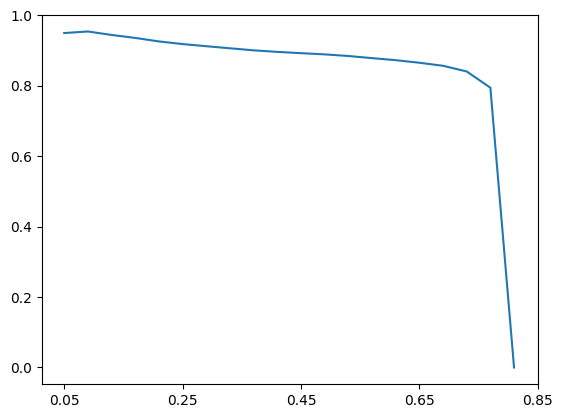

In [255]:
dice = []
for th in [0.05+0.05*i for i in range(20)]:
    prediction = nets[0](test_img_input).numpy()*614/1228 + nets[1](test_img_input).numpy()*106/1228 + nets[2](test_img_input).numpy()*62/1228 + nets[3](test_img_input).numpy()*85/1228 + nets[4](test_img_input).numpy()*80/1228 + nets[5](test_img_input).numpy()*65/1228 + nets[6](test_img_input).numpy()*77/1228 + nets[7](test_img_input).numpy()*69/1228 + nets[8](test_img_input).numpy()*70/1228
    #predicted_img = prediction[0,:,:,0]
    predicted_img_th = (prediction[0,:,:,0]>th)*1
    dice.append(Dice(ground_truth,predicted_img_th).numpy())
plt.plot(dice)
plt.xticks([0,5,10,15,20],[0.05,0.25,0.45,0.65,0.85])

In [257]:
dice3 = 0
for _ in range(n_val_img):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    a = nets[0](test_img_input).numpy()
    predicted_img_th = (a[0,:,:,0]>0.5)*1
    dice3 += Dice(ground_truth,predicted_img_th).numpy()
print(dice3/n_val_img)


0.8361205488000332


In [ ]:
dice = []
for th in [0.05+0.05*i for i in range(20)]:
    dice_th = 0
    for _ in range(n_val_img):
        test_image_batch, test_mask_batch = val_gen_ds.__next__()
        test_img = test_image_batch[0]
        ground_truth = test_mask_batch[0]
        test_img_norm = test_img[:,:]
        test_img_input = np.expand_dims(test_img_norm, 0)
        #a = nets[0](test_img_input).numpy()*614/1228 + nets[1](test_img_input).numpy()*106/1228 + nets[2](test_img_input).numpy()*62/1228 + nets[3](test_img_input).numpy()*85/1228 + nets[4](test_img_input).numpy()*80/1228 + nets[5](test_img_input).numpy()*65/1228 + nets[6](test_img_input).numpy()*77/1228 + nets[7](test_img_input).numpy()*69/1228 + nets[8](test_img_input).numpy()*70/1228
        a = nets[0](test_img_input).numpy()
        predicted_img_th = (a[0,:,:,0]>th)*1
        dice_th += Dice(ground_truth,predicted_img_th).numpy()
    dice.append(dice_th/n_val_img)


Text(0, 0.5, 'Dice')

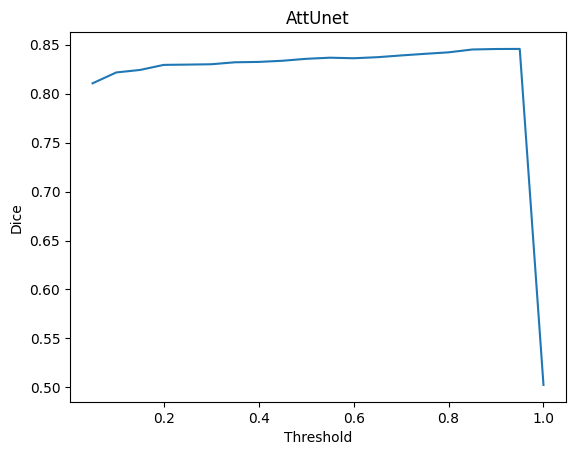

In [394]:
plt.plot([0.05+0.05*i for i in range(20)],dice)
plt.title("AttUnet")
plt.xlabel("Threshold")
plt.ylabel("Dice")

In [363]:
dice

[0.8106295864571094,
 0.8217461641930085,
 0.8242766181143039,
 0.8294608592682563,
 0.8297481223396861,
 0.8301095071453204,
 0.8321168261811115,
 0.8324940986895792,
 0.8336703985796439,
 0.8356570543359018,
 0.8367987380043086,
 0.8362452345553479,
 0.8373091990236035,
 0.8391069818303741,
 0.8407592281540002,
 0.8422847137774125,
 0.8451859433382454,
 0.845687229522471,
 0.8457712689022795,
 0.5024429967594278]

In [ ]:
#[614, 106, 62, 85, 80, 65, 77, 69, 70]
#[704, 169, 192, 163]

([<matplotlib.axis.XTick at 0x1fd2a9ab220>,
 [Text(0, 0, '0.05'),
  Text(5, 0, '0.25'),
  Text(10, 0, '0.45'),
  Text(15, 0, '0.65'),
  Text(20, 0, '0.85')])

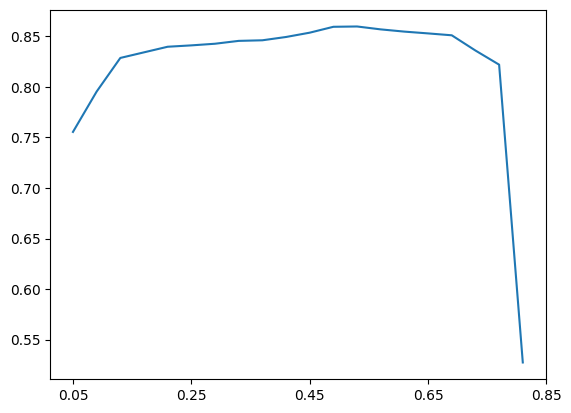

In [331]:
dice2 = []
for th in [0.05+0.05*i for i in range(20)]:
    for _ in range(n_val_img):
        test_image_batch, test_mask_batch = val_gen_ds.__next__()
        test_img = test_image_batch[0]
        ground_truth = test_mask_batch[0]
        test_img_norm = test_img[:,:]
        test_img_input = np.expand_dims(test_img_norm, 0)
        a = nets[0](test_img_input).numpy()*704/1228 + nets[1](test_img_input).numpy()*169/1228 + nets[3](test_img_input).numpy()*192/1228 + nets[4](test_img_input).numpy()*163/1228
        predicted_img_th = (a[0,:,:,0]>th)*1
        dice_th += Dice(ground_truth,predicted_img_th).numpy()
    dice2.append(dice_th/n_val_img)
plt.plot(dice2)
plt.xticks([0,5,10,15,20],[0.05,0.25,0.45,0.65,0.85])

In [196]:
scores = [0,0,0,0,0,0,0,0,0]
for _ in range(vspe):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    dice = 0
    for i,n in enumerate(nets):
        prediction = n(test_img_input).numpy()
        predicted_img_th = (prediction[0,:,:,0]>0.5)*1
        dd = Dice(ground_truth,predicted_img_th).numpy()
        if dd>dice:
            dice = dd
            max_i = i
    if dice > 0:
        scores[max_i]+=1
print(scores)

[614, 106, 62, 85, 80, 65, 77, 69, 70]


In [328]:
nets2 = [nets[0],nets[1],nets[3],nets[4]]

In [330]:
scores2 = [0,0,0,0]
for _ in range(vspe):
    test_image_batch, test_mask_batch = val_gen_ds.__next__()
    test_img = test_image_batch[0]
    ground_truth = test_mask_batch[0]
    test_img_norm = test_img[:,:]
    test_img_input = np.expand_dims(test_img_norm, 0)
    dice = 0
    for i,n in enumerate(nets2):
        prediction = n(test_img_input).numpy()
        predicted_img_th = (prediction[0,:,:,0]>0.5)*1
        dd = Dice(ground_truth,predicted_img_th).numpy()
        if dd>dice:
            dice = dd
            max_i = i
    if dice > 0:
        scores2[max_i]+=1
print(scores2)

[704, 169, 192, 163]
